# Example 0: advanced regular expression management

__The following practice is in part based on the course 'Applied text mining in Python', part of the 'Applied data Science using Python' by University of Michigan offered by Coursera.__
Dataset: https://github.com/sidsriv/Applied-text-mining-in-Python/blob/master/dates.txt

In this practice, you'll be working with **messy medical data** and using regex to extract relevant infromation from the data. 

Each line of the `dates.txt` file corresponds to a medical note. Each note has a date that needs to be extracted, but each date is encoded in one of many formats.

The goal of this assignment is to correctly identify all of the different date variants encoded in this dataset and to properly normalize and sort the dates. 

Here is a list of some of the variants you might encounter in this dataset:
* 04/20/2009; 04/20/09; 4/20/09; 4/3/09
* Mar-20-2009; Mar 20, 2009; March 20, 2009;  Mar. 20, 2009; Mar 20 2009;
* 20 Mar 2009; 20 March 2009; 20 Mar. 2009; 20 March, 2009
* Mar 20th, 2009; Mar 21st, 2009; Mar 22nd, 2009
* Feb 2009; Sep 2009; Oct 2010
* 6/2008; 12/2009
* 2009; 2010

Once you have extracted these date patterns from the text, the next step is to sort the documents in ascending chronological order accoring to the following rules:
* Assume all dates in xx/xx/xx format are mm/dd/yy
* Assume all dates where year is encoded in only two digits are years from the 1900's (e.g. 1/5/89 is January 5th, 1989)
* If the day is missing (e.g. 9/2009), assume it is the first day of the month (e.g. September 1, 2009).
* If the month is missing (e.g. 2010), assume it is the first of January of that year (e.g. January 1, 2010).
* Watch out for potential typos as this is a raw, real-life derived dataset.

In [3]:
import pandas as pd

doc = []
with open('dates.txt') as file:
    for line in file:
        doc.append(line)

df = pd.Series(doc)
df.head(10)

0         03/25/93 Total time of visit (in minutes):\n
1                       6/18/85 Primary Care Doctor:\n
2    sshe plans to move as of 7/8/71 In-Home Servic...
3                7 on 9/27/75 Audit C Score Current:\n
4    2/6/96 sleep studyPain Treatment Pain Level (N...
5                    .Per 7/06/79 Movement D/O note:\n
6    4, 5/18/78 Patient's thoughts about current su...
7    10/24/89 CPT Code: 90801 - Psychiatric Diagnos...
8                         3/7/86 SOS-10 Total Score:\n
9             (4/10/71)Score-1Audit C Score Current:\n
dtype: object

In [4]:
# think about a regexp to extract all dates in different formats...!
data = df.str.extractall(r'((?P<m1>\d{1,2})[-/](?:(?P<d1>\d{1,2})[-/])?(?P<y1>\d{4}|\d{2})|(?:(?P<d2>\d{1,2})[a-z]{,2}.?\s?)?(?P<m2>Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*.?\s?(?:(?P<d3>\d{1,2})[a-z]{,2}.?\s?)?(?P<y2>\d{4})|(?:\b|\D)(?P<y3>\d{4})(?:\b|\D))')

# we have different patterns and several matches for each document
data.iloc[[9,10,11,12,150,200,300,400,500],]

0   m1   d1    y1   d2   m2   d3    y2    y3
    match                                                              
9   0                4/10/71    4   10    71  NaN  NaN  NaN   NaN   NaN
10  0                5/11/85    5   11    85  NaN  NaN  NaN   NaN   NaN
    1                  16/22   16  NaN    22  NaN  NaN  NaN   NaN   NaN
11  0                4/09/75    4   09    75  NaN  NaN  NaN   NaN   NaN
147 0            30 May 2001  NaN  NaN   NaN   30  May  NaN  2001   NaN
197 0      February 18, 1981  NaN  NaN   NaN  NaN  Feb   18  1981   NaN
292 0          November 1995  NaN  NaN   NaN  NaN  Nov  NaN  1995   NaN
392 0                 5/2000    5  NaN  2000  NaN  NaN  NaN   NaN   NaN
491 0                   2009  NaN  NaN   NaN  NaN  NaN  NaN   NaN  2009

In [5]:
# create a DataFrame to store the normalized date for each document
res = pd.DataFrame(index=df.index, columns=['date'])
res['doc'] = df
res

,date,doc
0,NaN,03/25/93 Total time of visit (in minutes):\n
1,NaN,6/18/85 Primary Care Doctor:\n
2,NaN,sshe plans to move as of 7/8/71 In-Home Servic...
3,NaN,7 on 9/27/75 Audit C Score Current:\n
4,NaN,2/6/96 sleep studyPain Treatment Pain Level (N...
...,...,...
495,NaN,1979 Family Psych History: Family History of S...
496,NaN,therapist and friend died in ~2006 Parental/Ca...
497,NaN,2008 partial thyroidectomy\n
498,NaN,sPt describes a history of sexual abuse as a c...


In [6]:
# define the dictionary to convert months into numbers
month = {"Jan":"01","Feb":"02","Mar":"03","Apr":"04","May":"05","Jun":"06","Jul":"07","Aug":"08","Sep":"09","Oct":"10","Nov":"11","Dec":"12"}

In [7]:
# for each index (i.e. for each document)
for i in df.index:

    # get all matches for the document
    d = data.xs(i)
    # get the id of the match we think to be most relevant 
    j = (d.notnull().sum(axis=1) + d[0].str.len() / 100).idxmax()
    # get the best match
    dj = d.xs(j)    

    # retrieve the day
    dd = dj['d1']         # use d1
    if(pd.isnull(dd)):
        dd = dj['d2']     # if null use d2
    if(pd.isnull(dd)):  
        dd = dj['d3']     # if null use d2
    if(pd.isnull(dd)):  
        dd = '01'         # if null it's the first day of the month

    # retrieve the month
    mm = dj['m1']         # use m1
    if(pd.isnull(mm)):
        mm = dj['m2']     # if null use m2
    if(pd.isnull(mm)):  
        mm = '01'         # if null it's the first month of the year

    # retrieve the year
    yyyy = dj['y1']       # use y1
    if(pd.isnull(yyyy)):
        yyyy = dj['y2']   # if null use y2
    if(pd.isnull(yyyy)):
        yyyy = dj['y3']   # if null use y3
    if(pd.isnull(yyyy)):  
        yyyy = '1900'     # if null it's 1900

    # normalize the day
    if(len(dd)==1):
        dd = "0" + dd
    
    # normalize the month
    if(len(mm)==1):
        mm = "0" + mm
    elif(len(mm)==3):
        mm = month[mm]

    # normalize the year
    if(len(yyyy)==2):
        yyyy = "19" + yyyy

    # if month greater than 12 and day less than 12, then the format mm/dd/yy is actually dd/mm/yy -> swap dd with mm
    if(mm>'12' and dd<='12'):
        tmp = dd
        dd = mm
        mm = tmp
        
    # register the normalized date for the i-th document
    res['date'].loc[i] = yyyy + "-" + mm + "-" + dd

print(res)

           date                                                doc
0    1993-03-25       03/25/93 Total time of visit (in minutes):\n
1    1985-06-18                     6/18/85 Primary Care Doctor:\n
2    1971-07-08  sshe plans to move as of 7/8/71 In-Home Servic...
3    1975-09-27              7 on 9/27/75 Audit C Score Current:\n
4    1996-02-06  2/6/96 sleep studyPain Treatment Pain Level (N...
..          ...                                                ...
495  1979-01-01  1979 Family Psych History: Family History of S...
496  2006-01-01  therapist and friend died in ~2006 Parental/Ca...
497  2008-01-01                       2008 partial thyroidectomy\n
498  2005-01-01  sPt describes a history of sexual abuse as a c...
499  1980-01-01  . In 1980, patient was living in Naples and de...

[500 rows x 2 columns]


In [8]:
# sort documents by date
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'max_colwidth', 999):  # printing options
    display(res.sort_values(by=['date'], ascending = True))

,date,doc
9,1971-04-10,(4/10/71)Score-1Audit C Score Current:\n
84,1971-05-18,5/18/71 Total time of visit (in minutes):\n
2,1971-07-08,sshe plans to move as of 7/8/71 In-Home Services: None\n
53,1971-07-11,7/11/71 SOS-10 Total Score:\n
28,1971-09-12,9/12/71 [report_end]\n
474,1972-01-01,"sPatient reported losing three friends that passed away during his deployment, including a close friend Jacques, and two other friends that he lived with for a period of time. A fourth friend passed away prior to his deployment in 1972. Patient reported thinking about his friends daily and described his feelings of grief as remaining constant since they died. Alcohol Use: How often did you have a drink containing alcohol in the past year: Two to four times a month (2 points)\n"
153,1972-01-13,13 Jan 1972 Primary Care Doctor:\n
13,1972-01-26,1/26/72 Communication with referring physician?: Not Done\n
129,1972-05-06,06 May 1972 SOS-10 Total Score:\n
98,1972-05-13,5/13/72 Other Adult Mental Health Outcomes Scales Used:\n


## Example 1: Power method to extract one eigenvalue only

In [9]:
import numpy as np
X = np.array([[5, 4, 2], [1, 2, 2], [1, 2, 2]])
print(X)

[[5 4 2]
 [1 2 2]
 [1 2 2]]


In [10]:
n=3

In [11]:
x = np.zeros(n)

In [12]:

# Reading initial guess vector
print('Enter initial guess vector: ')
for i in range(n):
    x[i] = float(input( 'x['+str(i)+']='))

Enter initial guess vector: 
x[0]=1
x[1]=1
x[2]=1


In [13]:
tolerable_error = float(input('Enter tolerable error: '))

Enter tolerable error: 0.001


In [14]:
# Reading maximum number of steps
max_iteration = int(input('Enter maximum number of steps: '))

Enter maximum number of steps: 10


In [15]:
# Power Method Implementation
lambda_old = 1.0
condition =  True
step = 1
while condition:
    # Multiplying a and x
    x = np.matmul(X,x)
    
    # Finding new Eigen value and Eigen vector
    lambda_new = max(abs(x))
    
    x = x/lambda_new
    
    # Displaying Eigen value and Eigen Vector
    print('\nSTEP %d' %(step))
    print('----------')
    print('Eigen Value = %0.4f' %(lambda_new))
    print('Eigen Vector: ')
    for i in range(n):
        print('%0.3f\t' % (x[i]))
    
    # Checking maximum iteration
    step = step + 1
    if step > max_iteration:
        print('Not convergent in given maximum iteration!')
        break
    
    # Calculating error
    error = abs(lambda_new - lambda_old)
    print('Error='+ str(error))
    lambda_old = lambda_new
    condition = error > tolerable_error


STEP 1
----------
Eigen Value = 11.0000
Eigen Vector: 
1.000	
0.455	
0.455	
Error=10.0

STEP 2
----------
Eigen Value = 7.7273
Eigen Vector: 
1.000	
0.365	
0.365	
Error=3.2727272727272725

STEP 3
----------
Eigen Value = 7.1882
Eigen Vector: 
1.000	
0.342	
0.342	
Error=0.5390374331550802

STEP 4
----------
Eigen Value = 7.0524
Eigen Vector: 
1.000	
0.336	
0.336	
Error=0.13586213536150904

STEP 5
----------
Eigen Value = 7.0149
Eigen Vector: 
1.000	
0.334	
0.334	
Error=0.037520524734323324

STEP 6
----------
Eigen Value = 7.0042
Eigen Vector: 
1.000	
0.334	
0.334	
Error=0.010618009348509538

STEP 7
----------
Eigen Value = 7.0012
Eigen Vector: 
1.000	
0.333	
0.333	
Error=0.0030254633872495162

STEP 8
----------
Eigen Value = 7.0003
Eigen Vector: 
1.000	
0.333	
0.333	
Error=0.0008637462989584677


In [16]:
import numpy as np
import scipy.linalg as la

In [17]:
results = la.eig(X)
print(results[0])

[7.+0.j 2.+0.j 0.+0.j]


## Example 2: PCA in text mining (1)

In [18]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

def vectorizing(data):
    vec = CountVectorizer()
    X = vec.fit_transform(data)
    df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
    return df

def find_principal_components(n, data):
    pca = PCA(n_components = n)
    principalComponents = pca.fit_transform(data)
    return pd.DataFrame(pca.components_, columns=data.columns)

def find_variance_explained(n, data):
    pca = PCA(n_components = n)
    principalComponents = pca.fit_transform(data)
    return pca.explained_variance_ratio_



In [19]:
text = ['Texas real estate agent Ryan Williams',
        'part mob Trump storm administration Capitol congress continue insist innocence',
        'even face charge breach Capitol guilt heart Ryan', 
        'tell today Pelosi show glad Ryan Williams there because witness history Trump administration', 
        'never get  chance do again Texas Capitol there mob', 
        'storm Pelosi laptop invade office congress Pelosi Trump Biden prison guilt prison breach steal laptop',
        'Trump Williams Biden Trump president elect president Trump']

df = vectorizing(text)

print(df) # 7 row x 44 columns

   administration  again  agent  because  ...  today  trump  williams  witness
0               0      0      1        0  ...      0      0         1        0
1               1      0      0        0  ...      0      1         0        0
2               0      0      0        0  ...      0      0         0        0
3               1      0      0        1  ...      1      1         1        1
4               0      1      0        0  ...      0      0         0        0
5               0      0      0        0  ...      0      1         0        0
6               0      0      0        0  ...      0      3         1        0

[7 rows x 44 columns]


In [20]:
principalDF = find_principal_components(2, df)

print(principalDF) # 2 rows x 44 columns


   administration     again     agent  ...     trump  williams   witness
0       -0.047409 -0.083647 -0.061637  ...  0.221641 -0.070288 -0.029229
1        0.051772 -0.084410 -0.022809  ...  0.629815  0.255983  0.062849

[2 rows x 44 columns]


In [21]:
import numpy as np


In [22]:
principalDF = find_principal_components(4, df.transpose())
print(principalDF) # 2 rows x 44 columns

          0         1         2         3         4         5         6
0 -0.129217  0.047998 -0.100645  0.021819 -0.292573  0.803860  0.488472
1  0.092074  0.103515 -0.155248  0.365111 -0.032929 -0.494576  0.760072
2 -0.175071  0.535256 -0.000346 -0.703259  0.343934 -0.070775  0.254907
3 -0.291339  0.590347 -0.527191  0.425188  0.050126  0.053212 -0.320237


In [23]:
principal_VE_DF = find_variance_explained(4, df.transpose())
print(principal_VE_DF)

[0.27389369 0.22689191 0.15128386 0.11723622]


In [24]:
n=4
pca = PCA(n_components = n)
principalComponents = pca.fit_transform(df)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4'])

In [25]:
loadings

,PC1,PC2,PC3,PC4
0,-0.047409,0.051772,0.108670,0.343975
1,-0.083647,-0.084410,-0.078101,0.053544
2,-0.061637,-0.022809,0.050391,-0.124166
3,-0.029229,0.062849,0.246957,0.127245
4,0.227894,0.146157,-0.082260,-0.093280
5,0.172115,-0.160496,0.017451,-0.179722
6,-0.137028,-0.186198,-0.215088,0.090201
7,-0.083647,-0.084410,-0.078101,0.053544
8,-0.035201,-0.090711,0.001301,-0.180073
9,0.189136,-0.080862,-0.122137,0.217082


## Example 3: PCA in text mining (2)

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

In [26]:
# You should do some pre-processing on this!!!
corpus = [
     'This is a good document', 
     'This is a bad document',
     'This is a great document',
     'Is this a good document?',
]

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a Bag Of Words using unigrams (single words) and bigrams (two consecutive words) 
vectorizer = CountVectorizer(ngram_range = (1,2))

# Learn the vocabulary dictionary and return term-document matrix.
C = vectorizer.fit_transform(corpus)

In [28]:
# The term-document matrix is a sparse object
C

<4x15 sparse matrix of type '<class 'numpy.int64'>'
	with 28 stored elements in Compressed Sparse Row format>

In [29]:
# Convert to standard matrix
X = C.toarray()
X

array([[0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1],
       [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1],
       [0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1],
       [0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]])

In [30]:
# Print the features (corresponding to the columns of the term-document matrix)
vectorizer.get_feature_names()

['bad',
 'bad document',
 'document',
 'good',
 'good document',
 'great',
 'great document',
 'is',
 'is bad',
 'is good',
 'is great',
 'is this',
 'this',
 'this good',
 'this is']

## Standardization

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-0.57735027, -0.57735027,  0.        ,  1.        ,  1.        ,
        -0.57735027, -0.57735027,  0.        , -0.57735027,  1.73205081,
        -0.57735027, -0.57735027,  0.        , -0.57735027,  0.57735027],
       [ 1.73205081,  1.73205081,  0.        , -1.        , -1.        ,
        -0.57735027, -0.57735027,  0.        ,  1.73205081, -0.57735027,
        -0.57735027, -0.57735027,  0.        , -0.57735027,  0.57735027],
       [-0.57735027, -0.57735027,  0.        , -1.        , -1.        ,
         1.73205081,  1.73205081,  0.        , -0.57735027, -0.57735027,
         1.73205081, -0.57735027,  0.        , -0.57735027,  0.57735027],
       [-0.57735027, -0.57735027,  0.        ,  1.        ,  1.        ,
        -0.57735027, -0.57735027,  0.        , -0.57735027, -0.57735027,
        -0.57735027,  1.73205081,  0.        ,  1.73205081, -1.73205081]])

## Choosing the number of components
A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data. This can be determined by looking at the cumulative explained variance ratio as a function of the number of components:

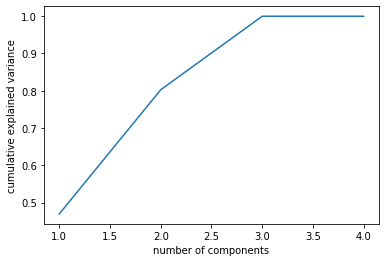

In [32]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA().fit(X)
nc  = list(range(1,1+len(pca.explained_variance_ratio_)))
ev  = np.cumsum(pca.explained_variance_ratio_)
plt.plot(nc, ev)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

This curve quantifies how much of the total variance is contained within the first N components. For example, we see that the first 2 components contain approximately 80% of the variance, while we need 3 components to describe 100% of the variance. __Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in multiple observations.__

In [33]:
import pandas as pd

# Keep only the first 2 components
pca = PCA(n_components = 2)

# Fit PCA and transform the data in the new coordinates
X_pca = pca.fit_transform(X)

# term-document matrix in the new coordinates
X_pca = pd.DataFrame(data = X_pca, columns = ['pc1', 'pc2'])
X_pca

,pc1,pc2
0,1.245195,-2.016716e-16
1,-2.261892,2.828427e+00
2,-2.261892,-2.828427e+00
3,3.278590,-8.881784e-16


This is the term-document matrix in the new coordinates. It is much smaller than the original one. We achieved this at the price of losing 20% of information contained in the original dataset. The new coordinates are linear combinations of the original features.

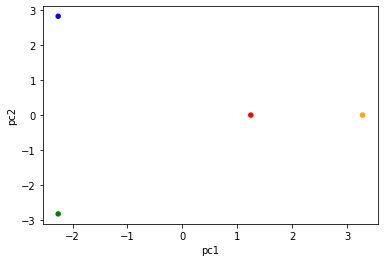

In [34]:
# plot the documents in the new 2-dimesional space
X_pca.plot(kind = 'scatter', x = 'pc1', y = 'pc2', color = ['red','blue','green','orange'])
plt.show()

The distance between the first (red), second (blue), and third (green) document is the same; while the 4-th (orange) document is closer, i.e. more similar, to the first one.

## How to transform new texts in the new coordinates

In [35]:
# new texts
corpus_new = [
    'this is a great document',
    'this is another good document',
    'this is another great document',
]

# term-document matrix originated by the pre-trained vectorizer
C_new = vectorizer.transform(corpus_new)

# convert from sparse to standard matrix
X_new = C_new.toarray()

# scale with the pre-trained scaler
X_new = scaler.transform(X_new)

# new coordinates originated by the pre-trained PCA 
pca.transform(X_new)

array([[-2.26189222e+00, -2.82842712e+00],
       [ 9.50456391e-01,  2.25220156e-16],
       [-1.72650078e+00, -1.88561808e+00]])

## Remarks!
This is just a simple example to illustrate PCA and let visualize the data in a 2-dimensional space. In real applications:
- the number of documents should be greater than the number of features
- the term-document matrix is huge
- there are several thousands of features
- several hundreds or thousands of principal components are kept (i.e. the reduced vector space is still high-dimensional and cannot be visualized)